Two Sigma Connect: Rental Listing Inquiries competition using some naive features, cv-statistic on manager_id's interest_level, tf-idf on feature, and kmeans clustering on latitude and longitute. 

Trained with xgboost using 5-fold cross-validation

In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix

from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
train_df = pd.read_json("train.json")
test_df = pd.read_json("test.json")
ids = test_df['listing_id'].values

train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [3]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=321, num_rounds=2000):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.02
    param['max_depth'] = 6
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 1
    param['subsample'] = 0.7
    param['colsample_bytree'] = 0.7
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=20, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model


In [4]:
test_df.loc[17808,'bathrooms'] = 1.5
test_df.loc[22737, 'bathrooms'] = 1
test_df.loc[837, 'bathrooms'] = 1.5
train_df["price"] = train_df["price"].clip(upper=13000)

In [5]:
train_df["logprice"] = np.log(train_df["price"])
test_df["logprice"] = np.log(test_df["price"])

train_df["price_t"] =train_df["price"]/(train_df["bedrooms"]+1.0)
test_df["price_t"] = test_df["price"]/(test_df["bedrooms"]+1.0)

#train_df['bed_vs_bath'] = np.where((train_df['bedrooms'] > train_df['bathrooms']), 1, 0)
#test_df['bed_vs_bath'] = np.where((test_df['bedrooms'] > test_df['bathrooms']), 1, 0)

train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

train_df['price_per_room'] = train_df['price']/(train_df['room_sum']+1.0)
test_df['price_per_room'] = test_df['price']/(test_df['room_sum']+1.0)

train_df['longitude_dist'] = train_df['longitude'] - train_df['longitude'].median()
test_df['longitude_dist'] = test_df['longitude'] - test_df['longitude'].median()

train_df['latitude_dist'] = train_df['latitude'] - train_df['latitude'].median()
test_df['latitude_dist'] = test_df['latitude'] - test_df['latitude'].median()


#train_df.loc[train_df['price_per_room'] == np.inf,'price_per_room'] = 0
#test_df.loc[test_df['price_per_room'] == np.inf, 'price_per_room'] = 0

train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)

train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))

train_df["created"] = pd.to_datetime(train_df["created"])
test_df["created"] = pd.to_datetime(test_df["created"])
train_df["created_year"] = train_df["created"].dt.year
test_df["created_year"] = test_df["created"].dt.year
train_df["created_month"] = train_df["created"].dt.month
test_df["created_month"] = test_df["created"].dt.month
train_df["created_day"] = train_df["created"].dt.day
test_df["created_day"] = test_df["created"].dt.day
train_df["created_hour"] = train_df["created"].dt.hour
test_df["created_hour"] = test_df["created"].dt.hour


train_df["pos"] = train_df.longitude.round(3).astype(str) + '_' + train_df.latitude.round(3).astype(str)
test_df["pos"] = test_df.longitude.round(3).astype(str) + '_' + test_df.latitude.round(3).astype(str)

vals = train_df['pos'].value_counts()
dvals = vals.to_dict()
train_df["density"] = train_df['pos'].apply(lambda x: dvals.get(x, vals.min()))
test_df["density"] = test_df['pos'].apply(lambda x: dvals.get(x, vals.min()))

features_to_use=["bathrooms", "bedrooms","latitude", "longitude","price","price_t","price_per_room", "logprice", "density",
"num_photos", "num_features", "num_description_words","listing_id", "created_year", "created_month", "created_day", "created_hour",
                "longitude_dist", "latitude_dist"]


cv-statistic on manager_id 

In [6]:
index=list(range(train_df.shape[0]))
random.shuffle(index)
a=[0]*len(train_df)
b=[0]*len(train_df)
c=[0]*len(train_df)

for i in range(5):
    building_level={}
    for j in train_df['manager_id'].values:
        building_level[j]=[0,0,0]
    
    test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
    train_index=list(set(index).difference(test_index))
    
    for j in train_index:
        temp=train_df.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp['manager_id']][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp['manager_id']][1]+=1
        if temp['interest_level']=='high':
            building_level[temp['manager_id']][2]+=1
            
    for j in test_index:
        temp=train_df.iloc[j]
        if sum(building_level[temp['manager_id']])!=0:
            a[j]=building_level[temp['manager_id']][0]*1.0/sum(building_level[temp['manager_id']])
            b[j]=building_level[temp['manager_id']][1]*1.0/sum(building_level[temp['manager_id']])
            c[j]=building_level[temp['manager_id']][2]*1.0/sum(building_level[temp['manager_id']])
            
train_df['manager_level_low']=a
train_df['manager_level_medium']=b
train_df['manager_level_high']=c

a=[]
b=[]
c=[]
building_level={}
for j in train_df['manager_id'].values:
    building_level[j]=[0,0,0]

for j in range(train_df.shape[0]):
    temp=train_df.iloc[j]
    if temp['interest_level']=='low':
        building_level[temp['manager_id']][0]+=1
    if temp['interest_level']=='medium':
        building_level[temp['manager_id']][1]+=1
    if temp['interest_level']=='high':
        building_level[temp['manager_id']][2]+=1

for i in test_df['manager_id'].values:
    if i not in building_level.keys():
        a.append(0)
        b.append(0)
        c.append(0)
    else:
        a.append(building_level[i][0]*1.0/sum(building_level[i]))
        b.append(building_level[i][1]*1.0/sum(building_level[i]))
        c.append(building_level[i][2]*1.0/sum(building_level[i]))
test_df['manager_level_low']=a
test_df['manager_level_medium']=b
test_df['manager_level_high']=c

features_to_use.append('manager_level_low') 
features_to_use.append('manager_level_medium') 
features_to_use.append('manager_level_high')

quanitify categoric data + tfidf on **features** 

In [7]:
categorical = ["display_address", "manager_id", "building_id"]
for f in categorical:
        if train_df[f].dtype=='object':
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            features_to_use.append(f)

train_df['features'] = train_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))
test_df['features'] = test_df["features"].apply(lambda x: " ".join(["_".join(i.split(" ")) for i in x]))

tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

leakage feature 

In [8]:
image_date = pd.read_csv("listing_image_time.csv")

# rename columns so you can join tables later on
image_date.columns = ["listing_id", "time_stamp"]

#reassign the only one timestamp from April, all others from Oct/Nov
image_date.loc[80240,"time_stamp"] = 1478129766 

image_date["img_date"]                  = pd.to_datetime(image_date["time_stamp"], unit="s")
image_date["img_days_passed"]           = (image_date["img_date"].max() - image_date["img_date"]).astype("timedelta64[D]").astype(int)
image_date["img_date_month"]            = image_date["img_date"].dt.month
image_date["img_date_week"]             = image_date["img_date"].dt.week
image_date["img_date_day"]              = image_date["img_date"].dt.day
image_date["img_date_dayofweek"]        = image_date["img_date"].dt.dayofweek
image_date["img_date_dayofyear"]        = image_date["img_date"].dt.dayofyear
image_date["img_date_hour"]             = image_date["img_date"].dt.hour
image_date["img_date_monthBeginMidEnd"] = image_date["img_date_day"].apply(lambda x: 1 if x<10 else 2 if x<20 else 3)
image_date["img_total_days"] =   (image_date["img_date_month"] -10.0)*30 + image_date["img_date_day"] +  image_date["img_date_hour"] /25.0
image_date["img_diff_rank"]= image_date["img_total_days"]/(image_date["listing_id"]-6811956.0)

for col in image_date.columns:
    features_to_use.append(col)
features_to_use.remove('img_date')

In [9]:
train_df = pd.merge(train_df, image_date, on='listing_id', how='left')
test_df = pd.merge(test_df, image_date, on='listing_id', how='left')

train_df['listing_id'] = train_df['listing_id']-6811957.0
test_df['listing_id'] = test_df['listing_id']-6811957.0

train_df["total_days"] =   (train_df["created_month"] -4.0)*30 + train_df["created_day"] +  train_df["created_hour"] /25.0
test_df["total_days"] =(test_df["created_month"] -4.0)*30 + test_df["created_day"] +  test_df["created_hour"] /25.0        
train_df["diff_rank"]= train_df["total_days"]/(train_df["listing_id"]+1.0)
test_df["diff_rank"]= test_df["total_days"]/(test_df["listing_id"]+1.0)

In [10]:
#add_these = train_df.columns[50:]
#features_to_use.extend(add_these)

/Users/tannercarbonati/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/tannercarbonati/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


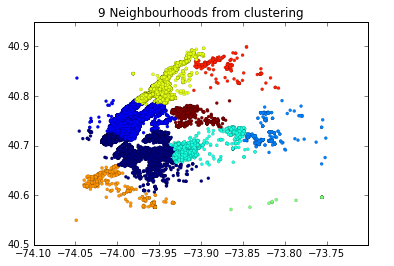

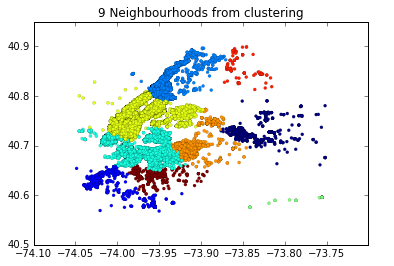

In [11]:
def cluster_latlon(n_clusters, data):  
    #split the data between "around NYC" and "other locations" basically our first two clusters 
    data_c=data[(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    data_e=data[~(data.longitude>-74.05)&(data.longitude<-73.75)&(data.latitude>40.4)&(data.latitude<40.9)]
    #put it in matrix form
    coords=data_c.as_matrix(columns=['latitude', "longitude"])
    
    brc = Birch(branching_factor=100, n_clusters=n_clusters, threshold=0.01,compute_labels=True)

    brc.fit(coords)
    clusters=brc.predict(coords)
    data_c.loc[:,"cluster_"+str(n_clusters)]=clusters
    data_e.loc[:,"cluster_"+str(n_clusters)]=-1 #assign cluster label -1 for the non NYC listings 
    data=pd.concat([data_c,data_e])
    plt.scatter(data_c["longitude"], data_c["latitude"], c=data_c["cluster_"+str(n_clusters)], s=10, linewidth=0.1)
    plt.title(str(n_clusters)+" Neighbourhoods from clustering")
    plt.show()
    return data['cluster_'+str(n_clusters)]

train_df['cluster_9'] = cluster_latlon(9, train_df)
test_df['cluster_9'] = cluster_latlon(9, test_df)
features_to_use.append('cluster_9')
train_df.fillna(-1, axis=1, inplace=True)
test_df.fillna(-1, axis=1, inplace=True)

In [12]:
def count_col(df, col):
    counts = df.groupby(col).size().to_frame().rename(columns={0: col + "_counts"})
    df = df.join(counts, on=col)
    features_to_use.append(counts.columns[0])
    return df

train_df = count_col(train_df, "latitude")
test_df = count_col(test_df, "latitude")

train_df = count_col(train_df, "longitude")
test_df = count_col(test_df, "longitude")

train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))

In [13]:
stda=StandardScaler()  
X = train_X.toarray()
X_test = test_X.toarray()
X_test = stda.fit_transform(X_test)
X = stda.transform(X)

In [14]:
from sklearn import cross_validation
cv_scores=[]
kf = cross_validation.KFold(train_df.shape[0], n_folds=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf:
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, model = runXGB(dev_X, dev_y, val_X, val_y)
    cv_scores.append(log_loss(val_y, preds))
    print(cv_scores)
    break

/Users/tannercarbonati/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-mlogloss:1.0845	test-mlogloss:1.08473
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
[20]	train-mlogloss:0.878503	test-mlogloss:0.88483
[40]	train-mlogloss:0.758552	test-mlogloss:0.770209
[60]	train-mlogloss:0.683614	test-mlogloss:0.700298
[80]	train-mlogloss:0.634407	test-mlogloss:0.655496
[100]	train-mlogloss:0.600388	test-mlogloss:0.62575
[120]	train-mlogloss:0.575708	test-mlogloss:0.605175
[140]	train-mlogloss:0.557285	test-mlogloss:0.59056
[160]	train-mlogloss:0.54306	test-mlogloss:0.5801
[180]	train-mlogloss:0.531262	test-mlogloss:0.571696
[200]	train-mlogloss:0.521285	test-mlogloss:0.565273
[220]	train-mlogloss:0.512401	test-mlogloss:0.560142
[240]	train-mlogloss:0.504737	test-mlogloss:0.555933
[260]	train-mlogloss:0.497393	test-mlogloss:0.552336
[280]	train-mlogloss:0.490782	test-mlogloss:0.54918
[300]	train-mlogloss:0.484837	test-mlogloss:0.546587
[320]	train-mlogl

Stopping. Best iteration:

[1257]	train-mlogloss:0.336388	test-mlogloss:0.521271

[0.52138732668574783]